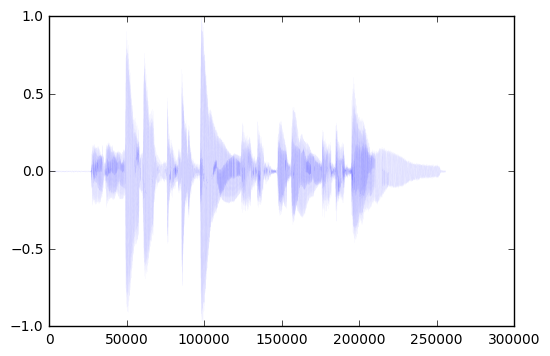

In [2]:
'''
only works for piano, what if the sound is being replaced the exact same frequency?
piano because it dampens
'''

import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd
import soundfile as sf
import time
import os

start_time = time.time()

# read file
fileDir = os.path.dirname(os.path.realpath('__file__'))
short_file_name = '../sounds/ttls u3.wav'
file_name = os.path.join(fileDir, short_file_name)
file_name = os.path.abspath(os.path.realpath(file_name))
ref, sample_rate = sf.read(file_name)  # not mp3 please

t_start = 0.0
t_end = 5.8
signal = ref[int(t_start * 44100): int(t_end * 44100), 0]
signal_length = len(signal)

# add noise so that silent parts will not give ambiguous values
# signal = np.add(signal, 0.001*np.random.randn(len(signal)))

# sd.play(signal, sample_rate)
# print "--- %s seconds --- the sound is played" % (time.time() - start_time)

plt.plot(signal, lw=0.01)
plt.show()

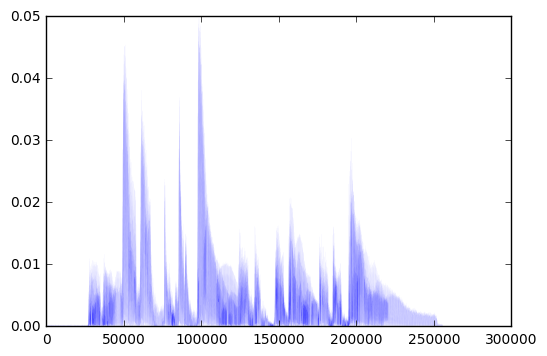

In [3]:
# taking absolute
#signal_square = np.multiply(signal, signal)
signal_square = np.absolute(signal)
signal_square = 0.05 * np.array(signal_square)  # forgot why did I wrote this

plt.plot(signal_square, lw=0.01)
plt.show()

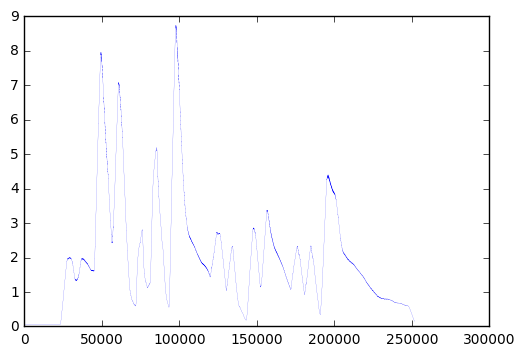

In [4]:
# the size of the window should never be related to the frequency, which is unknown
window_size = 4096

window_type = 'rect'
# rect, trig, or sin2

if window_type == 'rect':
    energy = [np.sum(signal_square[x:x + window_size]) for x in range(signal_length - window_size)] # rectangular window
elif window_type == 'sin2':
    window_function = [(np.sin(np.pi * x / window_size)) ** 2 for x in range(window_size)]
    energy = [np.sum(np.multiply(signal_square[x:x + window_size], window_function)) for x in range(signal_length - window_size)]
    #energy = 1 / (float(window_size)) ** (3.0 / 4.0) * np.array(energy)  # maybe not necessary
elif window_type == 'trig':
    window_function = [1.0 - np.absolute(2*x / window_size - 1.0) for x in range(window_size)]
    energy = [np.sum(np.multiply(signal_square[x:x + window_size], window_function)) for x in range(signal_length - window_size)]
    #energy = 1 / (float(window_size)) ** (3.0 / 4.0) * np.array(energy)  # maybe not necessary
energy = 1.0 / (float(window_size)) ** (1.0 / 4.0) * np.array(energy)

plt.plot(energy, lw=0.1)
plt.show()

--- 8.83000016212 seconds --- energy calculations are done
--- 15.6749999523 seconds --- plotting


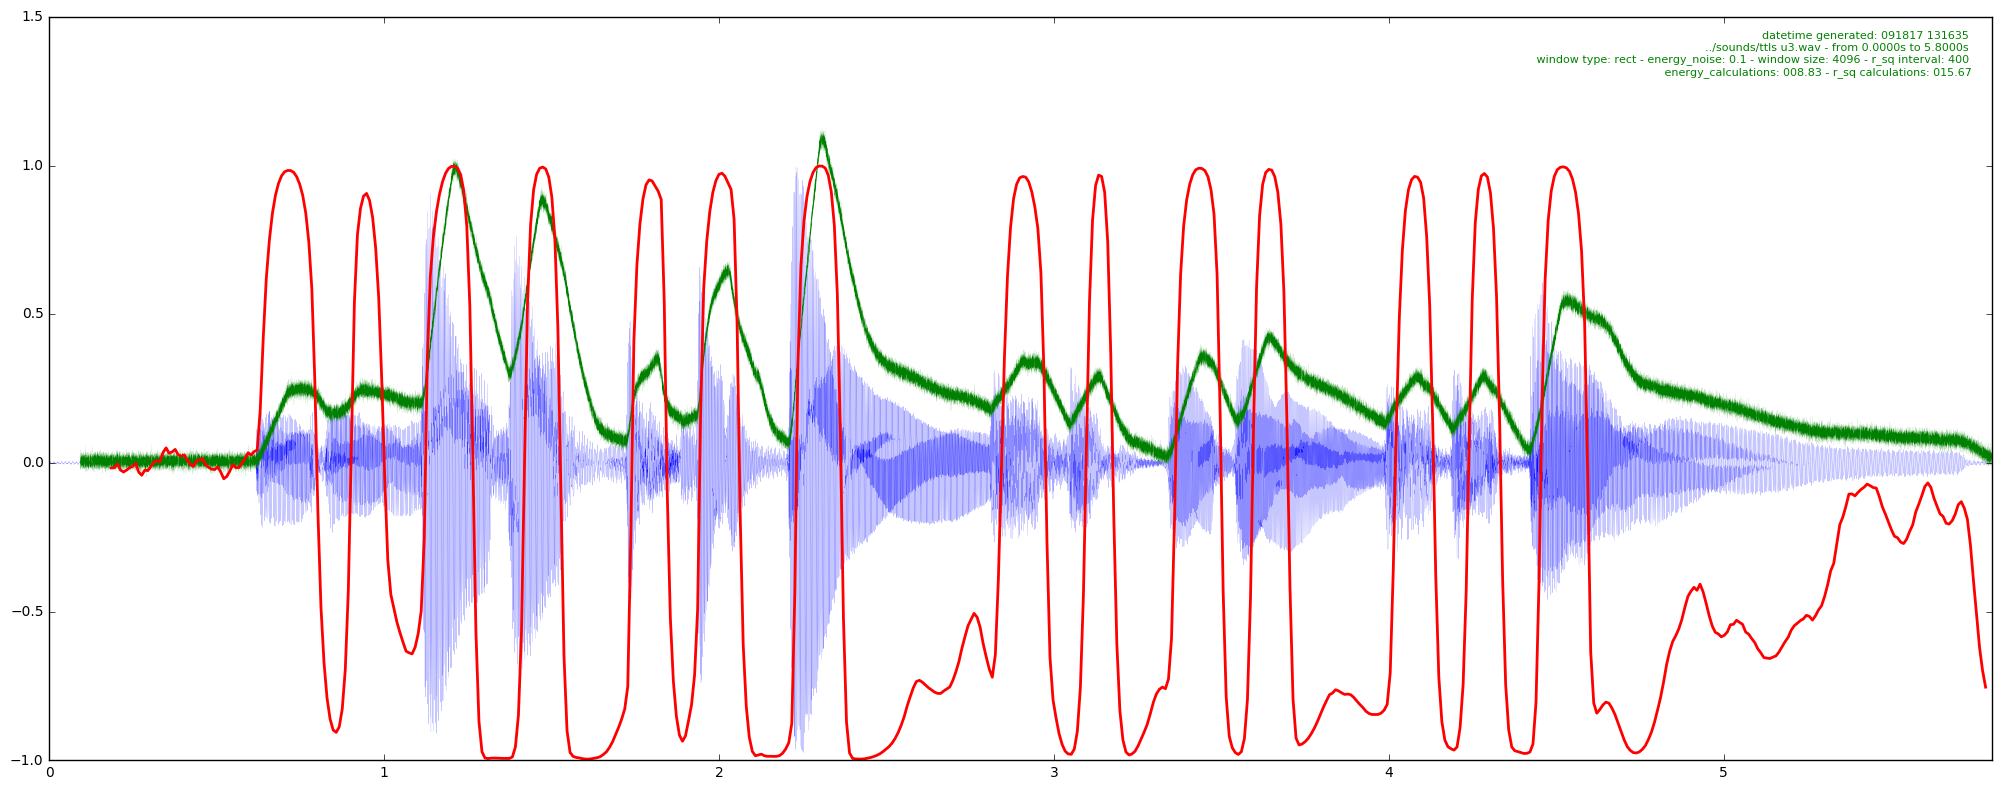

In [5]:
energy_noise = 0.1
if energy_noise != 0:
    energy = np.add(energy, energy_noise*np.random.randn(len(energy)))

energy_time = time.time() - start_time
print("--- %s seconds --- energy calculations are done" % energy_time)

# derivative = [np.arctan(44100*(energy[x+1] - energy[x])) for x in range(len(energy) - 1)]

interval = 400
r_list_length = ((signal_length - 2 * window_size) // interval)
r_list = [0] * r_list_length
r_list_x_series = [0] * r_list_length

for series_number in range(r_list_length):
    x = series_number * interval
    x_mean = x + window_size / 2.0
    y_mean = np.sum(energy[x:x + window_size]) / window_size
    r_num = np.sum([(energy[t + x] - y_mean) * (t + x - x_mean) for t in range(window_size)])
    r_dim = np.sqrt(np.sum([(t + x - x_mean) ** 2 for t in range(window_size)]) * np.sum(
        [(energy[t + x] - y_mean) ** 2 for t in range(window_size)]))
    # x - x_mean can be simplified I guess
    if np.absolute(r_dim) < 0.001:
        print("zero")
    r = r_num / r_dim
    r_list_x_series[series_number] = t_start + (x + window_size*2.0)/sample_rate
    r_list[series_number] = r

r_sq_time = time.time() - (energy_time + start_time)
print("--- %s seconds --- plotting" % r_sq_time)

time_string = time.strftime('%x %X')
time_string = time_string.replace(':', '')
time_string = time_string.replace(r'/', '')

annotation = 'datetime generated: {} \n' \
             '{} - from {:.4f}s to {:.4f}s \n '\
             'window type: {} - energy_noise: {} - window size: {} - r_sq interval: {} \n '\
             'energy_calculations: {:06.2f} - r_sq calculations: {:06.2f}' \
    .format(time_string, short_file_name, t_start, t_end, window_type, energy_noise, 
            window_size, interval, energy_time, r_sq_time)

fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
ax.set_xlim(left=t_start, right=t_end)

plt.tight_layout()

ax.text(0.99, 0.98, annotation,
        verticalalignment='top', horizontalalignment='right',
        transform=ax.transAxes,
        color='green', fontsize=8)


time_x_series = np.arange(t_start, t_end+0.01, 1.0/sample_rate)
time_x_series = time_x_series[:signal_length]
energy_x_series = np.arange(t_start + float(window_size)/sample_rate, t_end+0.01, 1.0/sample_rate)
energy_x_series = energy_x_series[:signal_length - window_size]
ax.plot(time_x_series, signal, lw=0.08, color="blue")

energy = 1.0 / (float(window_size)) ** (1.0 / 4.0) * np.array(energy)  # much time spent finding out you need to 'float'
ax.plot(energy_x_series, energy, lw=0.04, color="green")
ax.plot(r_list_x_series, r_list, lw=2.0, color="red")
# plt.plot(derivative, lw=0.2)
# sd.play(signal, sample_rate)

# plt.savefig("plots/{}.svg".format(time_string), bbox_inches='tight')
plt.show()